In [68]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

%matplotlib inline

register_matplotlib_converters()
sns.set(style="darkgrid", font_scale=1.5)

LENGTH = 600
LOOK_AHEAD_LENGTH = 40

In [69]:
print(tf.__version__)
tf.config.experimental.list_physical_devices()

2.3.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [70]:
# model = models.load_model('../../models/12kepochs500back40forward_encodedecode')


# Train Model

In [71]:
def shapeData(data, length, look_ahead_length):
    hist = []
    target = []

    for i in range(len(data)-length-look_ahead_length):
        x = data[i:i+length]
        y = data[i+length:i+length+look_ahead_length]
        hist.append(x)
        target.append(y)
    
    # Convert into numpy arrays and shape correctly (len(dataset), length) and (len(dataset), 1) respectivly
    hist = np.array(hist)
    target = np.array(target)
    hist = hist.reshape((len(hist), length, 1))

    return(hist, target)

In [72]:
def trainModel(datasets, length, model=None, quiet=False):
    for dataset in datasets:
        X_train, y_train = shapeData(dataset, length, LOOK_AHEAD_LENGTH)

        if not model:
            # Create model and compile if not already passed a model
            model = tf.keras.Sequential()
            model.add(layers.LSTM(units=20, input_shape=(length,1), dropout=0.2, activation='tanh'))
            model.add(layers.RepeatVector(LOOK_AHEAD_LENGTH))
            model.add(layers.LSTM(units=50, return_sequences=True, dropout=0.2, activation='tanh'))
            model.add(layers.TimeDistributed(layers.Dense(20, activation='tanh')))
            model.add(layers.TimeDistributed(layers.Dense(1)))
            model.compile(optimizer='adam', loss='mean_squared_error')
            print(model.summary())
        else:
            print("Continuing training from where we left off...")

        # Perform training
        output = 1
        if quiet:
            output = 0
        history = model.fit(X_train, y_train, epochs=1000, batch_size=128, verbose=output, shuffle=False)

        # Show loss
        if not quiet:
            loss = history.history['loss']
            epoch_count = range(1, len(loss) + 1)
            plt.figure(figsize=(6,4))
            plt.plot(epoch_count, loss, 'r--')
            plt.legend(['Training Loss'])
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()

    return model

In [73]:
def scaleData(paths):
    scaler = MinMaxScaler()
    datasets = []
    for path in paths:
        # perform partial fits on all datasets
        
        new_df = pd.DataFrame()
        new_df["price"] = pd.read_csv(path)[["high_price","low_price"]].mean(axis=1)
        
        datasets.append(new_df)

        scaler = scaler.partial_fit(datasets[-1])
    for i in range(len(datasets)):
        # once all partial fits have been performed, transform every file
        datasets[i] = scaler.transform(datasets[i])
    return (datasets, scaler)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 20)                1760      
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 40, 20)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 40, 50)            14200     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 40, 20)            1020      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 40, 1)             21        
Total params: 17,001
Trainable params: 17,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
452/452 [==============================] - 15s 33ms/step - loss: 0.0035
Epoch 2/1000
452/452 [====

452/452 [==============================] - 15s 33ms/step - loss: 9.3806e-04
Epoch 85/1000
452/452 [==============================] - 15s 33ms/step - loss: 9.3686e-04
Epoch 86/1000
452/452 [==============================] - 15s 34ms/step - loss: 9.2393e-04
Epoch 87/1000
452/452 [==============================] - 15s 33ms/step - loss: 9.0254e-04
Epoch 88/1000
452/452 [==============================] - 15s 33ms/step - loss: 8.9580e-04
Epoch 89/1000
452/452 [==============================] - 15s 34ms/step - loss: 8.8993e-04
Epoch 90/1000
452/452 [==============================] - 15s 34ms/step - loss: 8.8528e-04
Epoch 91/1000
452/452 [==============================] - 15s 33ms/step - loss: 8.6262e-04
Epoch 92/1000
452/452 [==============================] - 15s 34ms/step - loss: 8.6268e-04
Epoch 93/1000
452/452 [==============================] - 15s 33ms/step - loss: 8.4543e-04
Epoch 94/1000
452/452 [==============================] - 15s 34ms/step - loss: 8.3967e-04
Epoch 95/1000
452/452 [=

452/452 [==============================] - 15s 33ms/step - loss: 4.4417e-04
Epoch 175/1000
452/452 [==============================] - 15s 34ms/step - loss: 4.4390e-04
Epoch 176/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.4305e-04
Epoch 177/1000
452/452 [==============================] - 15s 34ms/step - loss: 4.4228e-04
Epoch 178/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.3942e-04
Epoch 179/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.3486e-04
Epoch 180/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.3765e-04
Epoch 181/1000
452/452 [==============================] - 15s 34ms/step - loss: 4.3845e-04
Epoch 182/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.3706e-04
Epoch 183/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.3268e-04
Epoch 184/1000
452/452 [==============================] - 15s 33ms/step - loss: 4.2837e-04
Epoch 185/1000

452/452 [==============================] - 15s 34ms/step - loss: 3.5818e-04
Epoch 264/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.5713e-04
Epoch 265/1000
452/452 [==============================] - 15s 33ms/step - loss: 3.5841e-04
Epoch 266/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.5768e-04
Epoch 267/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.5162e-04
Epoch 268/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.5108e-04 1s 
Epoch 269/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.4791e-04
Epoch 270/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.4240e-04
Epoch 271/1000
452/452 [==============================] - 15s 33ms/step - loss: 3.3433e-04
Epoch 272/1000
452/452 [==============================] - 15s 34ms/step - loss: 3.3980e-04
Epoch 273/1000
452/452 [==============================] - ETA: 0s - loss: 3.3287e-0 - 15s 34ms/step -

452/452 [==============================] - 15s 34ms/step - loss: 2.8776e-04
Epoch 353/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.7908e-04
Epoch 354/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.8062e-04
Epoch 355/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.7866e-04
Epoch 356/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.7548e-04
Epoch 357/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.7405e-04
Epoch 358/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.7346e-04
Epoch 359/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.7605e-04
Epoch 360/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.6939e-04
Epoch 361/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.7350e-04
Epoch 362/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.7220e-04
Epoch 363/1000

452/452 [==============================] - 15s 33ms/step - loss: 2.3059e-04
Epoch 442/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.2722e-04
Epoch 443/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.2103e-04
Epoch 444/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.1784e-04
Epoch 445/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.1809e-04
Epoch 446/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.2097e-04
Epoch 447/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.2398e-04
Epoch 448/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.2094e-04
Epoch 449/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.1872e-04
Epoch 450/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.1646e-04
Epoch 451/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.1920e-04
Epoch 452/1000

452/452 [==============================] - 15s 34ms/step - loss: 2.1106e-04
Epoch 531/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0989e-04
Epoch 532/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.1111e-04
Epoch 533/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0698e-04 0s - loss: 2.0698e-0
Epoch 534/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0560e-04
Epoch 535/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.0664e-04
Epoch 536/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.1179e-04
Epoch 537/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.1090e-04
Epoch 538/1000
452/452 [==============================] - 15s 33ms/step - loss: 2.0933e-04
Epoch 539/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0975e-04
Epoch 540/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.07

452/452 [==============================] - 15s 34ms/step - loss: 1.9557e-04
Epoch 620/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9439e-04
Epoch 621/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9406e-04
Epoch 622/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9284e-04
Epoch 623/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9163e-04
Epoch 624/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9184e-04
Epoch 625/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9134e-04
Epoch 626/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9060e-04
Epoch 627/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9291e-04
Epoch 628/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9774e-04
Epoch 629/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9453e-04
Epoch 630/1000

452/452 [==============================] - 15s 34ms/step - loss: 1.9290e-04
Epoch 709/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9138e-04 0s - lo
Epoch 710/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9042e-04
Epoch 711/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9256e-04
Epoch 712/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8931e-04
Epoch 713/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8911e-04
Epoch 714/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.8721e-04
Epoch 715/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8799e-04
Epoch 716/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8829e-04
Epoch 717/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9122e-04
Epoch 718/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9381e-04
Epoch 

452/452 [==============================] - 15s 34ms/step - loss: 2.1449e-04
Epoch 798/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.1197e-04
Epoch 799/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0789e-04
Epoch 800/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0450e-04
Epoch 801/1000
452/452 [==============================] - 15s 34ms/step - loss: 2.0246e-04
Epoch 802/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9971e-04
Epoch 803/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9743e-04
Epoch 804/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9321e-04
Epoch 805/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9408e-04
Epoch 806/1000
452/452 [==============================] - 15s 34ms/step - loss: 1.9579e-04
Epoch 807/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9623e-04
Epoch 808/1000

452/452 [==============================] - 15s 33ms/step - loss: 1.8381e-04
Epoch 887/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8187e-04
Epoch 888/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8203e-04
Epoch 889/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8111e-04
Epoch 890/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8261e-04
Epoch 891/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7998e-04
Epoch 892/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7797e-04
Epoch 893/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7910e-04
Epoch 894/1000
452/452 [==============================] - 15s 32ms/step - loss: 2.0798e-04
Epoch 895/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9942e-04 0s - los
Epoch 896/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.9075e-04
Epoch

452/452 [==============================] - 15s 33ms/step - loss: 1.7970e-04
Epoch 976/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7976e-04
Epoch 977/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.8226e-04
Epoch 978/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7358e-04 0s - loss: 1
Epoch 979/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7254e-04
Epoch 980/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7689e-04
Epoch 981/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7824e-04
Epoch 982/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7910e-04
Epoch 983/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7407e-04
Epoch 984/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7806e-04
Epoch 985/1000
452/452 [==============================] - 15s 33ms/step - loss: 1.7658e-04
E

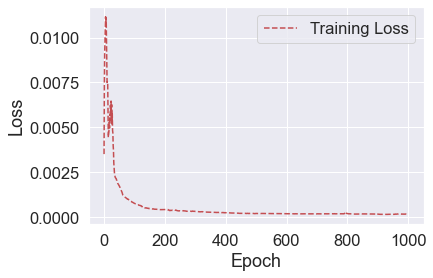

INFO:tensorflow:Assets written to: E-D-1k-600back-40forward-sm\assets
Completed 1k epochs and saved model
Continuing training from where we left off...
Epoch 1/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8579e-04
Epoch 2/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8670e-04
Epoch 3/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7940e-04
Epoch 4/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7670e-04
Epoch 5/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7678e-04
Epoch 6/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7722e-04
Epoch 7/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7919e-04
Epoch 8/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8056e-04
Epoch 9/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7818e-04
Epoch 10/1000
462/462 [========================

462/462 [==============================] - 15s 33ms/step - loss: 1.7772e-04
Epoch 90/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.9107e-04
Epoch 91/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7536e-04
Epoch 92/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7418e-04
Epoch 93/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7386e-04
Epoch 94/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7566e-04
Epoch 95/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7513e-04
Epoch 96/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7609e-04
Epoch 97/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7269e-04
Epoch 98/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7477e-04
Epoch 99/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6969e-04
Epoch 100/1000
462/462 [

462/462 [==============================] - 15s 33ms/step - loss: 1.6901e-04
Epoch 179/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6884e-04
Epoch 180/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6860e-04
Epoch 181/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7036e-04
Epoch 182/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6688e-04
Epoch 183/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6795e-04
Epoch 184/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7042e-04
Epoch 185/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7115e-04
Epoch 186/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6824e-04
Epoch 187/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7214e-04
Epoch 188/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7435e-04
Epoch 189/1000

462/462 [==============================] - 15s 33ms/step - loss: 1.6697e-04
Epoch 268/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6416e-04
Epoch 269/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6732e-04
Epoch 270/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6769e-04
Epoch 271/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6702e-04
Epoch 272/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6822e-04
Epoch 273/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6757e-04
Epoch 274/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7108e-04
Epoch 275/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6911e-04
Epoch 276/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7020e-04
Epoch 277/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6863e-04
Epoch 278/1000

462/462 [==============================] - 15s 33ms/step - loss: 1.6447e-04
Epoch 358/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6206e-04
Epoch 359/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6538e-04
Epoch 360/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6618e-04
Epoch 361/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6021e-04
Epoch 362/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6205e-04
Epoch 363/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6868e-04
Epoch 364/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6612e-04
Epoch 365/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6386e-04
Epoch 366/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6801e-04
Epoch 367/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6715e-04
Epoch 368/1000

462/462 [==============================] - 15s 33ms/step - loss: 1.7458e-04
Epoch 448/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7467e-04
Epoch 449/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6567e-04
Epoch 450/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6509e-04
Epoch 451/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6599e-04
Epoch 452/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6995e-04
Epoch 453/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6817e-04
Epoch 454/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.5984e-04
Epoch 455/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.5435e-04 0s - 
Epoch 456/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6247e-04
Epoch 457/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6401e-04
Epoch 45

462/462 [==============================] - 15s 33ms/step - loss: 1.9079e-04
Epoch 537/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8613e-04
Epoch 538/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8485e-04
Epoch 539/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8534e-04
Epoch 540/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8180e-04
Epoch 541/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7980e-04
Epoch 542/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8279e-04
Epoch 543/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8773e-04
Epoch 544/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8750e-04
Epoch 545/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8468e-04
Epoch 546/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.8356e-04
Epoch 547/1000

462/462 [==============================] - 15s 33ms/step - loss: 1.6548e-04
Epoch 626/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6502e-04
Epoch 627/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6656e-04 1
Epoch 628/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6466e-04
Epoch 629/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6249e-04 2 - ET
Epoch 630/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6294e-04
Epoch 631/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6041e-04
Epoch 632/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6071e-04
Epoch 633/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6158e-04
Epoch 634/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.5901e-04
Epoch 635/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.6087e-04
Epoch

462/462 [==============================] - 15s 33ms/step - loss: 1.7930e-04
Epoch 716/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7988e-04
Epoch 717/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7771e-04 0s - loss:
Epoch 718/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7911e-04
Epoch 719/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7884e-04
Epoch 720/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7772e-04
Epoch 721/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7895e-04
Epoch 722/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7943e-04
Epoch 723/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7864e-04
Epoch 724/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7341e-04
Epoch 725/1000
462/462 [==============================] - 15s 33ms/step - loss: 1.7440e-04
Epo

462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 811/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 812/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 813/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 814/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 815/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 816/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 817/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 818/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 819/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 820/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 821/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 8

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 908/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 909/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 910/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 911/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 912/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 913/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 914/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 915/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 916/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 917/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 918/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 9

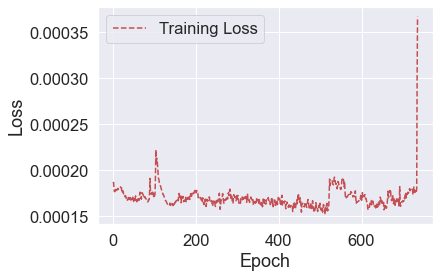

INFO:tensorflow:Assets written to: E-D-2k-600back-40forward-sm\assets
Completed 2k epochs and saved model
Continuing training from where we left off...
Epoch 1/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 2/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 3/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 4/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 5/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 6/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 7/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 8/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 9/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 10/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 11/1000
462/462 [====

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 98/1000
462/462 [==============================] - 15s 31ms/step - loss: nan
Epoch 99/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 100/1000
462/462 [==============================] - 15s 32ms/step - loss: nan
Epoch 101/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 102/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 103/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 104/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 105/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 106/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 107/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 108/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 109

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 195/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 196/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 197/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 198/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 199/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 200/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 201/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 202/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 203/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 204/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 205/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 2

462/462 [==============================] - 15s 33ms/step - loss: nan0s - loss:
Epoch 292/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 293/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 294/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 295/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 296/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 297/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 298/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 299/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 300/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 301/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 302/1000
462/462 [==============================] - 15s 33ms/step - loss: n

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 389/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 390/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 391/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 392/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 393/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 394/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 395/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 396/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 397/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 398/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 399/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 4

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 486/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 487/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 488/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 489/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 490/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 491/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 492/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 493/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 494/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 495/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 496/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 4

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 583/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 584/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 585/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 586/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 587/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 588/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 589/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 590/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 591/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 592/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 593/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 5

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 680/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 681/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 682/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 683/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 684/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 685/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 686/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 687/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 688/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 689/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 690/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 6

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 777/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 778/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 779/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 780/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 781/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 782/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 783/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 784/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 785/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 786/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 787/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 7

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 874/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 875/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 876/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 877/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 878/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 879/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 880/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 881/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 882/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 883/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 884/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 8

462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 971/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 972/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 973/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 974/1000
462/462 [==============================] - 15s 33ms/step - loss: nan0s - los
Epoch 975/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 976/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 977/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 978/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 979/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 980/1000
462/462 [==============================] - 15s 33ms/step - loss: nan
Epoch 981/1000
462/462 [==============================] - 15s 33ms/step - loss: nan

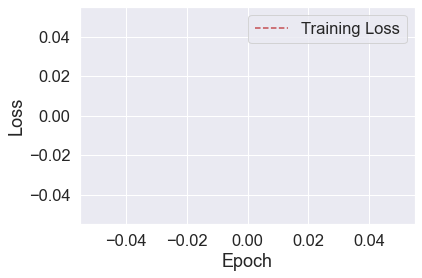

INFO:tensorflow:Assets written to: E-D-3k-600back-40forward-sm\assets
Completed 3k epochs and saved model
Continuing training from where we left off...
Epoch 1/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 2/1000
476/476 [==============================] - 15s 33ms/step - loss: nan
Epoch 3/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 4/1000
476/476 [==============================] - 16s 33ms/step - loss: nan
Epoch 5/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 6/1000
476/476 [==============================] - 15s 33ms/step - loss: nan
Epoch 7/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 8/1000
476/476 [==============================] - 16s 33ms/step - loss: nan
Epoch 9/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 10/1000
476/476 [==============================] - 15s 33ms/step - loss: nan
Epoch 11/1000
476/476 [====

Epoch 98/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 99/1000
476/476 [==============================] - 16s 33ms/step - loss: nan
Epoch 100/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 101/1000
476/476 [==============================] - 16s 33ms/step - loss: nan
Epoch 102/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 103/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 104/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 105/1000
476/476 [==============================] - 16s 33ms/step - loss: nan
Epoch 106/1000
476/476 [==============================] - 15s 32ms/step - loss: nan0s - loss: n
Epoch 107/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 108/1000
476/476 [==============================] - 15s 32ms/step - loss: nan
Epoch 109/1000
476/476 [==============================] - 16s 33ms

In [ ]:
model = None
for i in np.arange(1, 20):
    paths = ["../../data/ETH.csv"]
    datasets, scaler = scaleData(paths)
    model = trainModel(datasets, LENGTH, model)
    model.save(f"E-D-{i}k-600back-40forward-sm")
    print(f"Completed {i}k epochs and saved model")

## Test Model

In [ ]:
def testModel(model, path_to_testing_dataset, quiet=False):

    datasets, scaler = scaleData([path_to_testing_dataset])

    hist, actual = shapeData(datasets[0], LENGTH, LOOK_AHEAD_LENGTH)

    pred = model.predict(hist)

    
    # for p in pred:
    # pred_transformed.append(scaler.inverse_transform(p))
    pred_transformed = scaler.inverse_transform(pred[0])
    actual_transformed = scaler.inverse_transform(actual[0])
    hist_transformed = scaler.inverse_transform(hist[0])

    
    # print(pred[500])
    # print(hist[0])
    if not quiet:
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),pred_transformed, color='red', label='Prediction')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

        pred_transformed = scaler.inverse_transform(pred[900])
        actual_transformed = scaler.inverse_transform(actual[900])
        hist_transformed = scaler.inverse_transform(hist[900])
        plt.figure(figsize=(12,8))
        plt.plot(hist_transformed, color='blue', label='History')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),pred_transformed, color='red', label='Prediction')
        plt.plot(np.arange(len(hist_transformed)-1,len(hist_transformed)+LOOK_AHEAD_LENGTH-1),actual_transformed, color='purple', label='Actual')
        plt.title('ETH Price Prediction')
        plt.legend()
        plt.show()

    return


In [ ]:
testModel(model, "../../data/ETH.csv")

# Single Prediction

In [ ]:
# For example, if we just want to predict the next timestep in the dataset we can prepare it as such:

# 1. get the [length] last points from the data set since that's what we care about
length = LENGTH
whole_df = pd.read_csv('../../data/ETH.csv')
# most_recent_period = np.array(recent_history)
recent_history = pd.DataFrame({'price': whole_df[["high_price","low_price"]].mean(axis=1)}).tail(length)
recent_history = recent_history.set_index(pd.DatetimeIndex(pd.to_datetime(whole_df['begins_at'].tail(length))))

# 2. convert to numpy array 
most_recent_period = np.array(recent_history)

# 3. normalize data
scaler = MinMaxScaler()
most_recent_period_scaled = scaler.fit_transform(most_recent_period)

# 4. reshape to the 3D tensor we expected (1, length, 1)
most_recent_period_scaled_shaped = most_recent_period_scaled.reshape((1, length, 1))

# 5. Predict
prediction = model.predict(most_recent_period_scaled_shaped)
# print(prediction[0])
# 6. Un-normalize the data
result = scaler.inverse_transform(prediction[0])
recent_history_unscaled = scaler.inverse_transform(most_recent_period_scaled)
recent_history.price = recent_history_unscaled

# print(result)
pred_df = pd.DataFrame(result)
# pred_df = pred_df.set_index(pd.DatetimeIndex(pd.date_range(recent_history.index[-1], periods=len(result[0]), freq="15s")))
plt.figure(figsize=(20,8))
plt.plot(recent_history_unscaled)
plt.plot(np.arange(length, length+LOOK_AHEAD_LENGTH),result)
plt.show()